In [7]:
# Written by Rui Zhu (rzhu@eng.ucsd.edu)
# For CSE152B Spring 2020 HW1
# Apr 15, 2020

import os
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import viso2
import matplotlib.pyplot as plt
from skimage.io import imread
import time

def errorMetric(RPred, RGt, TPred, TGt):
    diffRot = (RPred - RGt)
    diffTrans = (TPred - TGt)
    errorRot = np.sqrt(np.sum(np.multiply(diffRot.reshape(-1), diffRot.reshape(-1))))
    errorTrans = np.sqrt(np.sum(np.multiply(diffTrans.reshape(-1), diffTrans.reshape(-1))))

    return errorRot, errorTrans

if_vis = True # set to True to do the visualization per frame; the images will be saved at '.vis/'. Turn off if you just want the camera poses and errors
if_on_screen = False # if True the visualization per frame is going to be displayed realtime on screen; if False there will be no display, but in both options the images will be saved

# parameter settings (for an example, please download
dataset_path = '../dataset'
# dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM' # On the ``ieng6.ucsd.edu`` server
img_dir      = os.path.join(dataset_path, 'sequences/00/image_0')
gt_dir       = os.path.join(dataset_path, 'poses/00.txt')
calibFile    = os.path.join(dataset_path, 'sequences/00/calib.txt')
border       = 50;
gap          = 15;

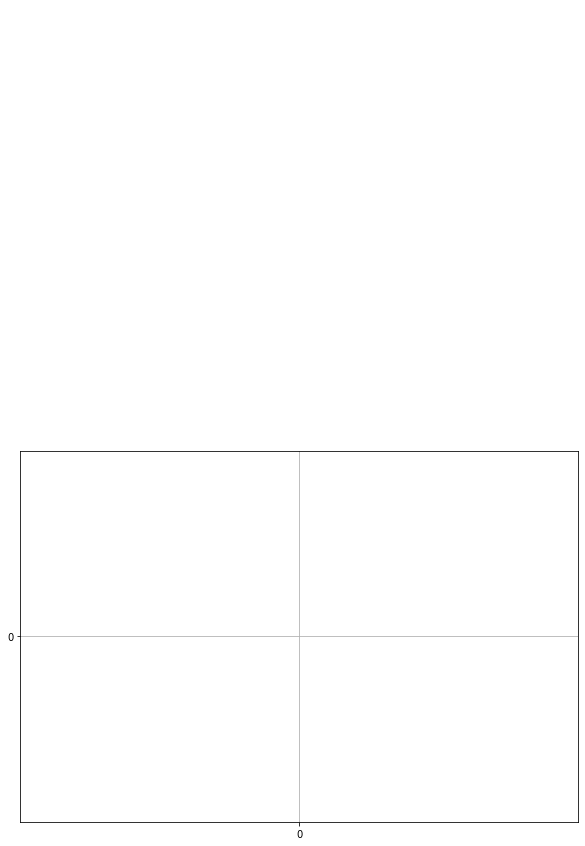

In [8]:
# Load the camera calibration information
with open(calibFile) as fid:
    calibLines = fid.readlines()
    calibLines = [calibLine.strip() for calibLine in calibLines]

calibInfo = [float(calibStr) for calibStr in calibLines[0].split(' ')[1:]]
# param = {'f': calibInfo[0], 'cu': calibInfo[2], 'cv': calibInfo[6]}

# Load the ground-truth depth and rotation
with open(gt_dir) as fid:
    gtTr = [[float(TrStr) for TrStr in line.strip().split(' ')] for line in fid.readlines()]
gtTr = np.asarray(gtTr).reshape(-1, 3, 4)

# param['height'] = 1.6
# param['pitch']  = -0.08
# param['match'] = {'pre_step_size': 64}
first_frame  = 0
last_frame   = 300
epi = 1e-8

# init visual odometry
params = viso2.Mono_parameters()
params.calib.f = calibInfo[0]
params.calib.cu = calibInfo[2]
params.calib.cv = calibInfo[6]
params.height = 1.6
params.pitch = -0.08
params.match.pre_step_size = 64


first_frame  = 0
last_frame   = 300

# init transformation matrix array
Tr_total = []
Tr_total_np = []
Tr_total.append(viso2.Matrix_eye(4))
Tr_total_np.append(np.eye(4))

# init viso module
visoMono = viso2.VisualOdometryMono(params)


if if_vis:
    save_path = 'vis'
    os.makedirs(save_path, exist_ok=True)

    # create figure
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot(211)
    ax1.axis('off')
    ax2 = plt.subplot(212)
    ax2.set_xticks(np.arange(-100, 100, step=10))
    ax2.set_yticks(np.arange(-500, 500, step=10))
    ax2.axis('equal')
    ax2.grid()
    if if_on_screen:
        plt.ion()
        plt.show()
    else:
        plt.ioff()

Mean Error Rotation: 8168113.22184
Mean Error Translation: 5092886065.98161
== [Result] Frame: 0, Matches 15, Inliers: 60.00
Saved at vis/frame000.jpg


<Figure size 432x288 with 0 Axes>

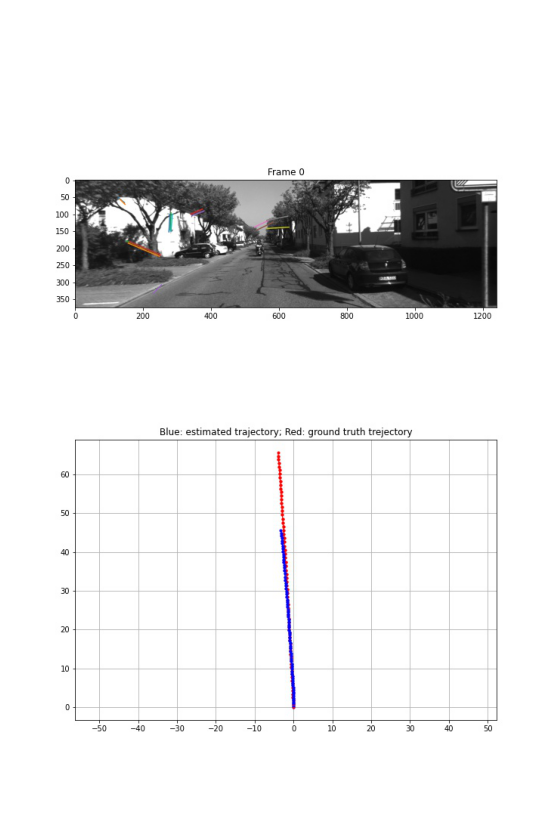

[[ 0.9943 -0.0106 -0.1056 -3.4084]
 [ 0.0098  0.9999 -0.0087 -0.6424]
 [ 0.1057  0.0076  0.9944 46.6443]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.08688
Mean Error Translation: 51.30843
== [Result] Frame: 1, Matches 320, Inliers: 85.00
Saved at vis/frame001.jpg
[[ 0.9938 -0.0101 -0.1107 -3.4562]
 [ 0.009   0.9999 -0.0105 -0.6468]
 [ 0.1108  0.0094  0.9938 47.1205]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.04529
Mean Error Translation: 25.84719
== [Result] Frame: 2, Matches 325, Inliers: 84.00
Saved at vis/frame002.jpg
[[ 0.9933 -0.011  -0.1154 -3.5088]
 [ 0.0096  0.9999 -0.012  -0.6534]
 [ 0.1155  0.0108  0.9932 47.6029]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03290
Mean Error Translation: 17.35619
== [Result] Frame: 3, Matches 329, Inliers: 79.94
Saved at vis/frame003.jpg
[[ 0.9926 -0.0113 -0.1206 -3.5684]
 [ 0.0098  0.9999 -0.0129 -0.6588]
 [ 0.1207  0.0116  0.9926 48.0803]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0

In [ ]:
# for all frames do
if_replace = False
errorTransSum = 0
errorRotSum = 0
errorRot_list = []
errorTrans_list =[]

for frame in range(first_frame, last_frame):
    # 1-based index
    k = frame-first_frame+1

    # read current images
    I = imread(os.path.join(img_dir, '%06d.png'%frame))
    assert(len(I.shape) == 2) # should be grayscale

    # compute egomotion
    process_result = visoMono.process_frame(I, if_replace)
    Tr = visoMono.getMotion()
    matrixer = viso2.Matrix(Tr)
    Tr_np = np.zeros((4, 4))
    Tr.toNumpy(Tr_np) # so awkward...

    # accumulate egomotion, starting with second frame
    if k > 1:
        if process_result is False:
            if_replace = True
            Tr_total.append(Tr_total[-1])
            Tr_total_np.append(Tr_total_np[-1])
        else:
            if_replace = False
            Tr_total.append(Tr_total[-1] * viso2.Matrix_inv(Tr))
            Tr_total_np.append(Tr_total_np[-1] @ np.linalg.inv(Tr_np)) # should be the same
            print(Tr_total_np[-1])

    # output statistics
    num_matches = visoMono.getNumberOfMatches()
    num_inliers = visoMono.getNumberOfInliers()
    matches = visoMono.getMatches()
    matches_np = np.empty([4, matches.size()])

    for i,m in enumerate(matches):
        matches_np[:, i] = (m.u1p, m.v1p, m.u1c, m.v1c)

    if if_vis:
        # update image
        ax1.clear()
        ax1.imshow(I, cmap='gray', vmin=0, vmax=255)
        if num_matches != 0:
            for n in range(num_matches):
                ax1.plot([matches_np[0, n], matches_np[2, n]], [matches_np[1, n], matches_np[3, n]])
        ax1.set_title('Frame %d'%frame)

        # update trajectory
        if k > 1:
            ax2.plot([Tr_total_np[k-2][0, 3], Tr_total_np[k-1][0, 3]], \
                [Tr_total_np[k-2][2, 3], Tr_total_np[k-1][2, 3]], 'b.-', linewidth=1)
            ax2.plot([gtTr[k-2][0, 3], gtTr[k-1][0, 3]], \
                [gtTr[k-2][2, 3], gtTr[k-1][2, 3]], 'r.-', linewidth=1)
        ax2.set_title('Blue: estimated trajectory; Red: ground truth trejectory')

        plt.draw()

    # Compute rotation
    Rpred_p = Tr_total_np[k-2][0:3, 0:3]
    Rpred_c = Tr_total_np[k-1][0:3, 0:3]
    Rpred = Rpred_c.transpose() @ Rpred_p
    Rgt_p = np.squeeze(gtTr[k-2, 0:3, 0:3])
    Rgt_c = np.squeeze(gtTr[k-1, 0:3, 0:3])
    Rgt = Rgt_c.transpose() @ Rgt_p
    # Compute translation
    Tpred_p = Tr_total_np[k-2][0:3, 3:4]
    Tpred_c = Tr_total_np[k-1][0:3, 3:4]
    Tpred = Tpred_c - Tpred_p
    Tgt_p = gtTr[k-2, 0:3, 3:4]
    Tgt_c = gtTr[k-1, 0:3, 3:4]
    Tgt = Tgt_c - Tgt_p
    # Compute errors
    errorRot, errorTrans = errorMetric(Rpred, Rgt, Tpred, Tgt)
    errorRotSum = errorRotSum + errorRot
    errorTransSum = errorTransSum + errorTrans
    # errorRot_list.append(errorRot)
    # errorTrans_list.append(errorTrans)
    print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1+epi)))
    print('Mean Error Translation: %.5f'%(errorTransSum / (k-1+epi)))



    print('== [Result] Frame: %d, Matches %d, Inliers: %.2f'%(frame, num_matches, 100*num_inliers/(num_matches+1e-8)))

    if if_vis:
        # input('Paused; Press Enter to continue') # Option 1: Manually pause and resume
        if if_on_screen:
            plt.pause(0.1) # Or Option 2: enable to this to auto pause for a while after daring to enable animation in case of a delay in drawing
        vis_path = os.path.join(save_path, 'frame%03d.jpg'%frame)
        fig.savefig(vis_path)
        print('Saved at %s'%vis_path)
        
        if frame % 50 == 0:
            plt.figure(figsize=(10, 15))
            plt.imshow(plt.imread(vis_path))
            plt.axis('off')
            plt.show()
        
# input('Press Enter to exit')